In [1]:
from helpers import get_data, get_client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
es = get_client()  
df = get_data("aggregated-curr-udpjitter-*", es)

Connected to Elasticsearch.


In [3]:
df['date'] = pd.to_datetime(df['date']) 
df = df[df['date'].dt.year == 2023]

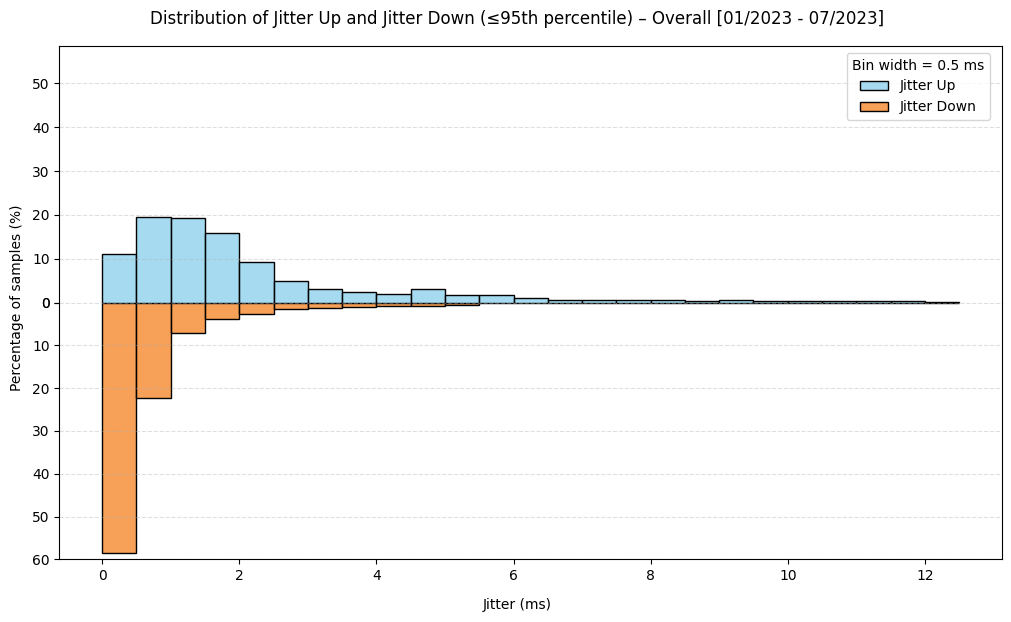

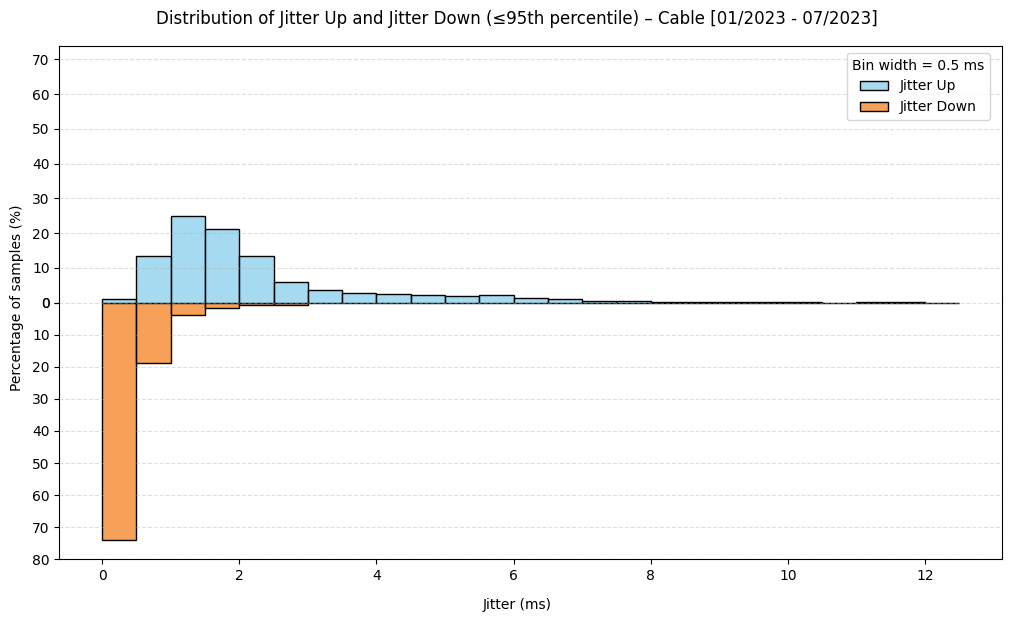

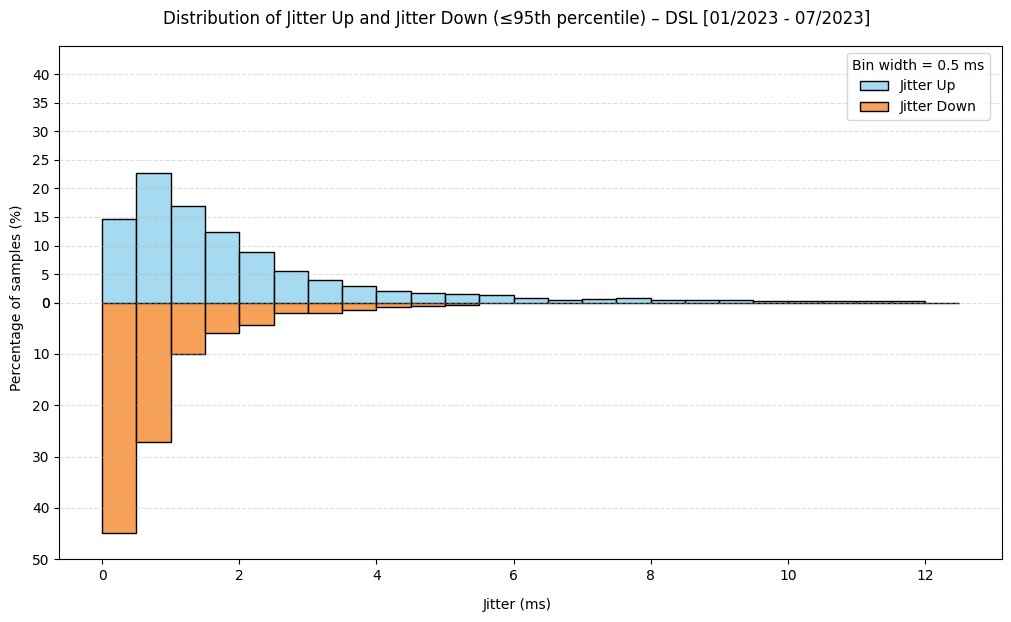

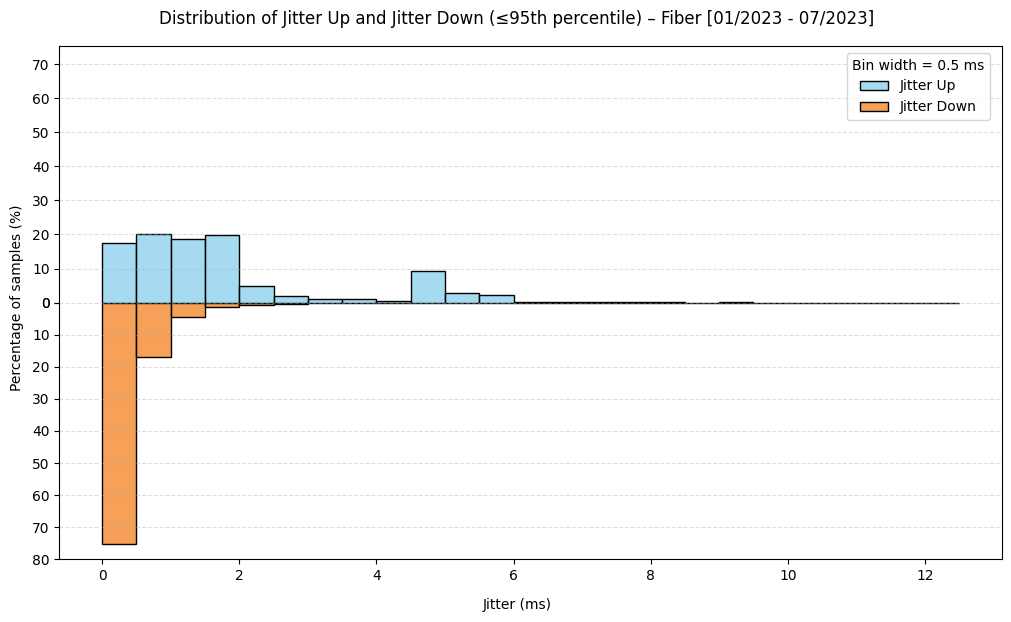

In [4]:
"""
Histogram of Jitter Up and Jitter Down
--------------------------------------
• One figure per technology (‘Overall’, ‘Cable’, ‘DSL’, ‘Fiber’)
• 0.5 ms-wide bins that are **identical** for every subplot and every figure
• Data above the global 95th-percentile is clipped away
• Top and bottom y-axes share the same percentage scale
"""

# ------------------------------------------------------------------
# 1.  GLOBAL SETTINGS (shared by *every* chart)
# ------------------------------------------------------------------
bin_width = 0.5  # ms

# 95th-percentile thresholds across the ENTIRE data set
up_thr_global   = df['jitter_up']  .quantile(0.95)
down_thr_global = df['jitter_down'].quantile(0.95)

# Common bin edges: start at the next lowest multiple of bin_width,
# end at the next highest multiple, and step by bin_width.
lo = np.floor(
        min(df['jitter_up'].min(), df['jitter_down'].min()) / bin_width
     ) * bin_width
hi = np.ceil(
        max(up_thr_global, down_thr_global) / bin_width
     ) * bin_width
edges = np.arange(lo, hi + bin_width, bin_width)   # inclusive upper edge

# ------------------------------------------------------------------
# 2.  LOOP OVER TECHNOLOGIES
# ------------------------------------------------------------------
for tech in ['Overall', 'Cable', 'DSL', 'Fiber']:
    # ---------- subset & clip to the GLOBAL 95th percentile ----------
    tmp = df if tech == 'Overall' else df[df['operator_technology'] == tech]

    jitter_up_clipped   = tmp.loc[tmp['jitter_up']   <= up_thr_global,   'jitter_up']
    jitter_down_clipped = tmp.loc[tmp['jitter_down'] <= down_thr_global, 'jitter_down']

    # ---------- figure & axes ----------------------------------------
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, figsize=(10, 6), sharex=True,
        gridspec_kw={'height_ratios': [1, 1], 'hspace': 0}
    )

    # ---------- top histogram (Jitter Up) ----------------------------
    sns.histplot(
        jitter_up_clipped,
        bins=edges, stat='percent',
        color='skyblue', edgecolor='black',
        ax=ax_top, label='Jitter Up'
    )
    ax_top.grid(True, axis='y', ls='--', alpha=.4)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.tick_params(axis='x', bottom=False, labelbottom=False)
    ax_top.set_ylabel('')

    # ---------- bottom histogram (Jitter Down) -----------------------
    sns.histplot(
        jitter_down_clipped,
        bins=edges, stat='percent',
        color='#f48120', edgecolor='black',
        ax=ax_bottom, label='Jitter Down'
    )
    ax_bottom.invert_yaxis()
    ax_bottom.grid(True, axis='y', ls='--', alpha=.4)
    ax_bottom.spines['top'].set_visible(False)
    ax_bottom.set_xlabel('')
    ax_bottom.set_ylabel('')

    # ---------- lock y-ranges to the same scale ----------------------
    max_up   = max(p.get_height() for p in ax_top.patches)
    max_down = max(p.get_height() for p in ax_bottom.patches)
    y_max = max(max_up, max_down)

    ax_top.set_ylim(0, y_max)
    ax_bottom.set_ylim(y_max, 0)          # inverted axis
    ticks = ax_top.get_yticks()
    ax_bottom.set_yticks(ticks)

    # ---------- shared labels & legend ------------------------------
    fig.text(0.5, 0, 'Jitter (ms)', ha='center', va='top')
    fig.text(0, 0.5, 'Percentage of samples (%)',
             ha='center', va='center', rotation='vertical')

    handles_top, labels_top = ax_top.get_legend_handles_labels()
    handles_bottom, labels_bottom = ax_bottom.get_legend_handles_labels()
    fig.legend(
        handles_top + handles_bottom,
        labels_top  + labels_bottom,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.92),
        title='Bin width = 0.5 ms'
    )

    plt.suptitle(
        f'Distribution of Jitter Up and Jitter Down (≤95th percentile) – {tech} [01/2023 - 07/2023]'
    )
    plt.tight_layout()
    plt.savefig(f'./plots/jitter/jitter_{tech}.png',
                dpi=600, bbox_inches='tight')
    plt.show()


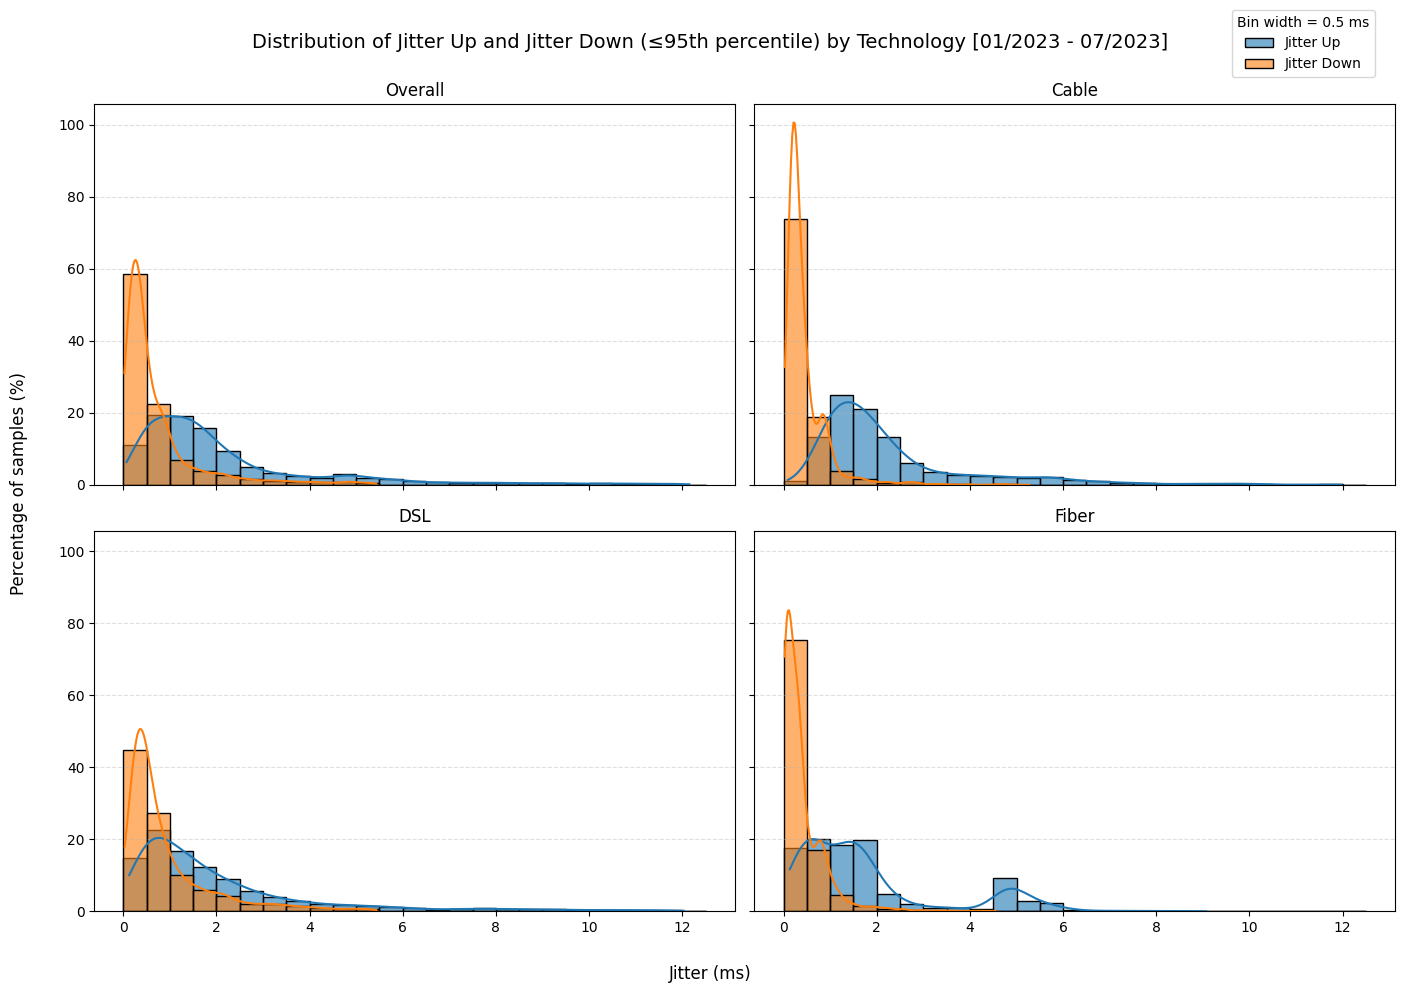

In [7]:
# ------------------------------------------------------------------
# 1. GLOBAL SETTINGS (shared by *every* subplot)
# ------------------------------------------------------------------
bin_width = 0.5  # ms

# drop NaNs so quantile/min ignore missing values
jup_all = df['jitter_up'].dropna()
jdn_all = df['jitter_down'].dropna()

if jup_all.empty and jdn_all.empty:
    raise ValueError("No valid jitter_up or jitter_down data to compute thresholds.")

# compute global 95th-percentile thresholds
up_thr_global   = jup_all.quantile(0.95)
down_thr_global = jdn_all.quantile(0.95)

# compute overall min and max-threshold
min_val = min(jup_all.min(), jdn_all.min())
max_thr = max(up_thr_global, down_thr_global)

# snap lo/hi to nearest multiples of bin_width
lo = np.floor(min_val / bin_width) * bin_width
hi = np.ceil (max_thr / bin_width) * bin_width

# sanity-check & exact bin count
diff   = hi - lo
if not np.isfinite(diff) or diff <= 0:
    raise ValueError(f"Invalid bin range: lo={lo}, hi={hi}")
n_bins = max(int(round(diff / bin_width)), 1)
edges  = lo + np.arange(n_bins + 1) * bin_width

# ------------------------------------------------------------------
# 2. PLOT 4-PANEL FIGURE
# ------------------------------------------------------------------
tech_list = ['Overall', 'Cable', 'DSL', 'Fiber']

fig, axes = plt.subplots(
    2, 2,
    figsize=(14, 10),
    sharex=True,
    sharey=True
)
axes = axes.flatten()

# collect legend handles/labels once
legend_handles = []
legend_labels  = []

for ax, tech in zip(axes, tech_list):
    # subset & clip to global thresholds
    tmp = df if tech == 'Overall' else df[df['operator_technology'] == tech]
    up_vals   = tmp['jitter_up'].dropna()
    down_vals = tmp['jitter_down'].dropna()

    up_clip   = up_vals[ up_vals   <= up_thr_global   ]
    down_clip = down_vals[ down_vals <= down_thr_global ]

    if up_clip.empty and down_clip.empty:
        ax.set_title(f"{tech}\n(no data)")
        continue

    # plot Jitter Up
    h_up = sns.histplot(
        up_clip, bins=edges, stat='percent', kde=True,
        alpha=0.6, edgecolor='black', label='Jitter Up',
        ax=ax
    )
    # plot Jitter Down
    h_down = sns.histplot(
        down_clip, bins=edges, stat='percent', kde=True,
        alpha=0.6, edgecolor='black', label='Jitter Down',
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title(tech)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)

    # capture legend entries once
    if not legend_handles:
        handles, labels = ax.get_legend_handles_labels()
        # take unique in order
        for h, l in zip(handles, labels):
            legend_handles.append(h)
            legend_labels.append(l)

# shared axis labels and suptitle
fig.supxlabel('Jitter (ms)',   fontsize=12, x=0.5, y=0.0)
fig.supylabel('Percentage of samples (%)', fontsize=12, x=0.0, y=0.5)
fig.suptitle('Distribution of Jitter Up and Jitter Down (≤95th percentile) by Technology [01/2023 - 07/2023]',
             fontsize=14, y=0.95)

# single legend for the whole figure
fig.legend(
    legend_handles,
    legend_labels,
    title=f'Bin width = {bin_width} ms',
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98)
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./plots/jitter/jitter_all_techs.png', dpi=600, bbox_inches='tight')
plt.show()
